In [2]:
using DataFrames, FileIO, DelimitedFiles
using Plots, Optim, LsqFit, JUMD
using Statistics, NamedArrays

In [182]:
# Get ready
dir_apo_hbo = "/home/pbarletta/labo/20/cph_obp/run/apo/hbond"

aa = 119
nstlim = 19500
phs = collect(30:5:75)
idx = collect(1:10)
pdt_steps = collect(0:1:7)
titratable_cnt = 36
titratable_resis = [4, 5, 7, 11, 13, 18, 20, 24, 27, 30, 33, 37, 39,
    40, 41, 42, 48, 52, 58, 59, 64, 69, 73, 77, 78, 82, 87, 93, 94,
    97, 99, 102, 109, 111, 114, 117];
titratable_resnames = ["GL4", "GL4", "LYS", "HIP", "GL4", "LYS", "GL4", "AS4", "LYS",
    "AS4", "GL4", "AS4", "GL4", "AS4", "LYS", "LYS", "GL4", "LYS",
    "AS4", "LYS", "LYS", "LYS", "GL4", "AS4", "GL4", "LYS", "AS4",
    "GL4", "GL4", "HIP", "LYS", "LYS", "LYS", "LYS", "LYS", "AS4"]

idx_of_titratable = fill(0, aa)
[ idx_of_titratable[titratable_resis[i]] = i for i in 1:titratable_cnt ];

titratable_residues = [ string(titratable_resnames[i], "_", titratable_resis[i]) 
    for i in 1:titratable_cnt ];

In [4]:
for i in 1:10
    global nhb_apo_idx = convert(Array{Float64, 1}, readdlm(joinpath(dir_apo_hbo, string(idx[i]),
            string("nhb_apo_", idx[i])))[2:end, 2])
    global nhb_apo_phs = convert(Array{Float64, 1}, readdlm(joinpath(dir_apo_hbo, string(phs[i], "ph"),
            string("nhb_apo_", phs[i])))[2:end, 2])

    sym_nhb_apo_idx = Symbol("nhb_apo_", idx[i])
    sym_nhb_apo_phs = Symbol("nhb_apo_", phs[i])
    eval(:($sym_nhb_apo_idx = nhb_apo_idx))
    eval(:($sym_nhb_apo_phs = nhb_apo_phs))
end

## hbonds count por pH

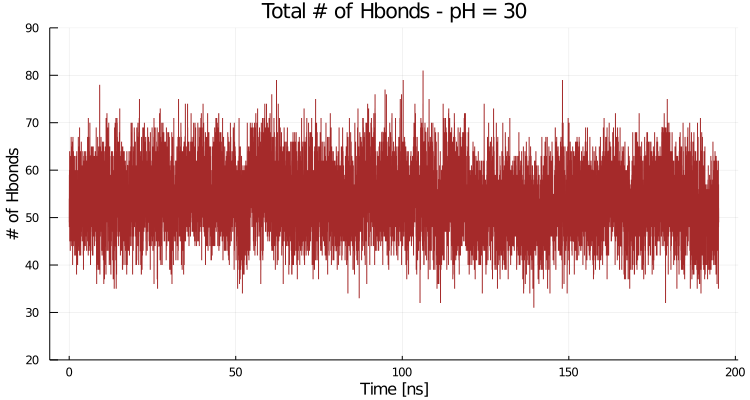

In [108]:
min_nhb = 20
max_nhb = 90
plot(collect(1:nstlim) ./ 100, nhb_apo_30,
    title = string("Total # of Hbonds - pH = ", 30), size = (750, 400),
    ylims = (min_nhb, max_nhb), label = false,
    linecolor = Colors.colorant"Brown",
    yaxis = "# of Hbonds", xaxis = "Time [ns]")

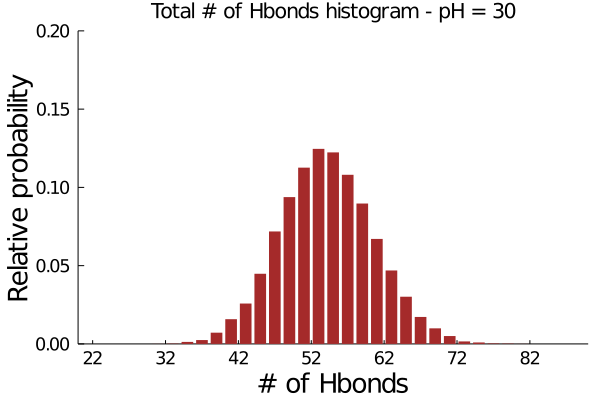

In [109]:
st = 2
bin_nhb = collect(min_nhb:st:max_nhb)
wgh_nhb = fill(1.0, length(nhb_apo_30))

# Histograma ponderado
Wbins_nhb, Whis_nhb = JUMD.weightedHist(nhb_apo_30, bin_nhb, wgh_nhb, true, false);

bar(Wbins_nhb, Whis_nhb,
    xlims = (min_nhb, max_nhb), ylims = (0, .2),
    xticks = min_nhb+st:10:max_nhb+st,
    linecolor = false, fillcolor = Colors.colorant"Brown",
    grid = false, legend = false,
    guidefont = font(18, "Arial"), tickfont = font(12, "Arial"),
    legendfont = font(12, "Arial"),
    title = string("Total # of Hbonds histogram - pH = ", 30),
    yaxis = "Relative probability", xaxis = "# of Hbonds")

In [7]:
vals = vcat([ mean(nhb_apo_30) std(nhb_apo_30) std(nhb_apo_30) / mean(nhb_apo_30) ],
    [ mean(nhb_apo_35) std(nhb_apo_35) std(nhb_apo_35) / mean(nhb_apo_35) ],
    [ mean(nhb_apo_40) std(nhb_apo_40) std(nhb_apo_40) / mean(nhb_apo_40) ])
    
NamedArray(vals, (string.(phs[1:3]), ["μ" ; "std" ; "μ/std"]))

3×3 Named Array{Float64,2}
A ╲ B │        μ       std     μ/std
──────┼─────────────────────────────
30    │  53.6252   6.40518  0.119443
35    │  55.5763   6.44623  0.115989
40    │  56.9156   6.48374  0.113918

## hbonds count por idx

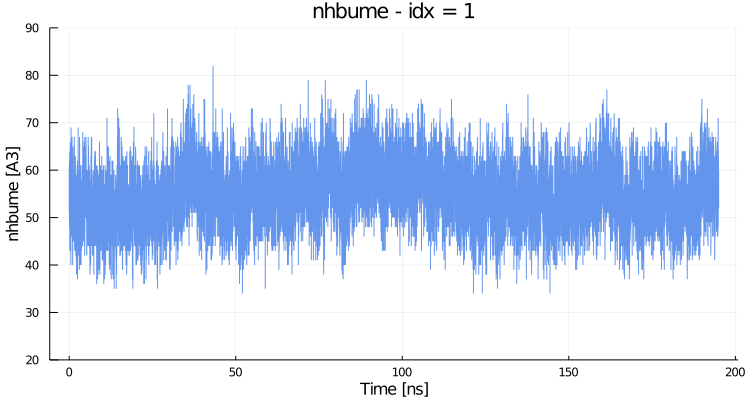

In [8]:
plot(collect(1:nstlim) ./ 100, nhb_apo_1,
    title = string("nhbume - idx = ", 1), size = (750, 400),
    ylims = (min_nhb, max_nhb), label = false,
    linecolor = Colors.colorant"CornflowerBlue",
    yaxis = "nhbume [A3]", xaxis = "Time [ns]")

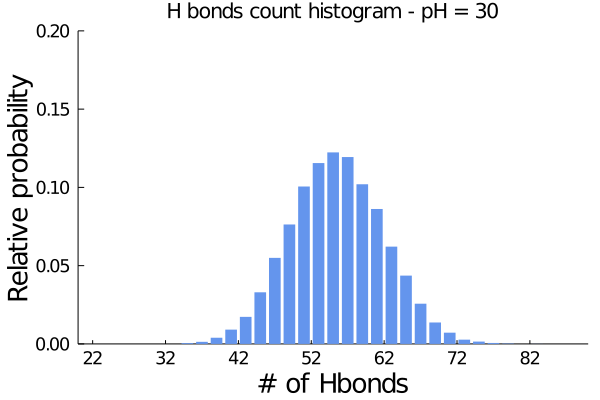

In [9]:
st = 2
bin_nhb = collect(min_nhb:st:max_nhb)
wgh_nhb = fill(1.0, length(nhb_apo_1))

# Histograma ponderado
Wbins_nhb, Whis_nhb = JUMD.weightedHist(nhb_apo_1, bin_nhb, wgh_nhb, true, false);

bar(Wbins_nhb, Whis_nhb,
    xlims = (min_nhb, max_nhb), ylims = (0, .2),
    xticks = min_nhb+st:10:max_nhb+st,
    linecolor = false, fillcolor = Colors.colorant"CornflowerBlue",
    grid = false, legend = false,
    guidefont = font(18, "Arial"), tickfont = font(12, "Arial"),
    legendfont = font(12, "Arial"),
    title = string("H bonds count histogram - pH = ", 30),
    yaxis = "Relative probability", xaxis = "# of Hbonds")

In [10]:
NamedArray([ mean(nhb_apo_1) std(nhb_apo_1) std(nhb_apo_1) / mean(nhb_apo_1) ],
    (["# of Hbonds"], ["μ" ; "std" ; "μ/std"]))

1×3 Named Array{Float64,2}
      A ╲ B │        μ       std     μ/std
────────────┼─────────────────────────────
# of Hbonds │  55.0166   6.39254  0.116193

## Conteo de puentesH de residuos titulables

In [238]:
nhb_cnt_apo_acc_phs = Array{Int64, 2}(undef, aa, 0)
nhb_cnt_apo_don_phs = Array{Int64, 2}(undef, aa, 0)

for ph in phs
    nhb_ser_apo_acc_ph = fill(0, (aa, nstlim))
    nhb_ser_apo_don_ph = fill(0, (aa, nstlim))
    
    temporal_acc = readdlm(joinpath(dir_apo_hbo, string(ph, "ph"),
        string("series_nhb_apo_gl4_as4_lys_acc_", ph)), header = true)
    
    temporal_don = readdlm(joinpath(dir_apo_hbo, string(ph, "ph"),
        string("series_nhb_apo_gl4_as4_lys_don_", ph)), header = true)
    
    res_hbo_apo_acc_phs = convert(Array{Bool, 2}, temporal_acc[1][:, 2:end])
    acceptor_donor_acc = convert(Array{String, 1}, temporal_acc[2][2:end])
    
    res_hbo_apo_don_phs = convert(Array{Bool, 2}, temporal_don[1][:, 2:end])
    acceptor_donor_don = convert(Array{String, 1}, temporal_don[2][2:end])
    

    for i = 1:nstlim  
        mascara_acc = findall(res_hbo_apo_acc_phs[i, :])
        mascara_don = findall(res_hbo_apo_don_phs[i, :])
        
        for j in mascara_acc
            acceptor, donor = split(acceptor_donor_acc[j], "-")
            don = parse(Int64, split(split(donor, "_")[2], "@")[1])
            acc = parse(Int64, split(split(acceptor, "_")[2], "@")[1])
            nhb_ser_apo_acc_ph[don, i] += 1
            nhb_ser_apo_acc_ph[acc, i] += 1
        end
        
        for j in mascara_don
            acceptor, donor = split(acceptor_donor_don[j], "-")
            acc = parse(Int64, split(split(acceptor, "_")[2], "@")[1])
            don = parse(Int64, split(split(donor, "_")[2], "@")[1])
            nhb_ser_apo_don_ph[don, i] += 1
            nhb_ser_apo_don_ph[acc, i] += 1
        end
    end

    nhb_cnt_apo_acc_ph = mapslices(x -> sum(x), nhb_ser_apo_acc_ph, dims = 2)[:, 1]
    global nhb_cnt_apo_acc_phs = hcat(nhb_cnt_apo_acc_phs, nhb_cnt_apo_acc_ph)
    
    nhb_cnt_apo_don_ph = mapslices(x -> sum(x), nhb_ser_apo_don_ph, dims = 2)[:, 1]
    global nhb_cnt_apo_don_phs = hcat(nhb_cnt_apo_don_phs, nhb_cnt_apo_don_ph)
    
end

(119, 1)  -  (119, 1)
(119, 2)  -  (119, 2)
(119, 3)  -  (119, 3)
(119, 4)  -  (119, 4)
(119, 5)  -  (119, 5)
(119, 6)  -  (119, 6)
(119, 7)  -  (119, 7)
(119, 8)  -  (119, 8)
(119, 9)  -  (119, 9)
(119, 10)  -  (119, 10)


In [240]:
nhb_cnt_apo_phs = nhb_cnt_apo_acc_phs .+ nhb_cnt_apo_don_phs;

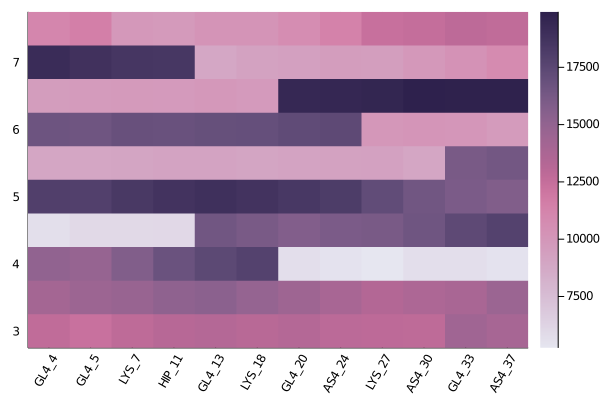

In [243]:
heatmap(titratable_residues[1:12], (phs ./ 10), nhb_cnt_apo_phs[titratable_resis[1:12], :],
    xrotation = 60, color = gradi)

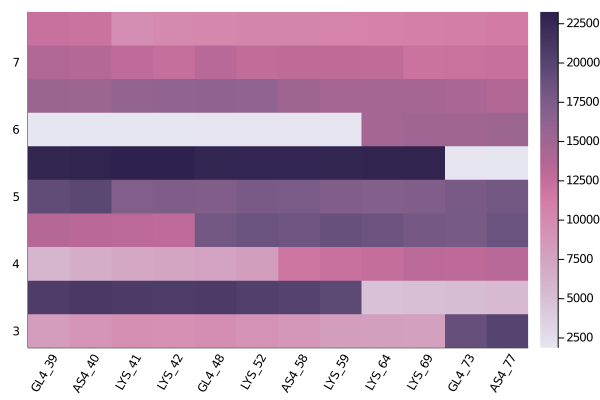

In [244]:
heatmap(titratable_residues[13:24], (phs ./ 10), nhb_cnt_apo_phs[titratable_resis[13:24], :],
    xrotation = 60, color = gradi)

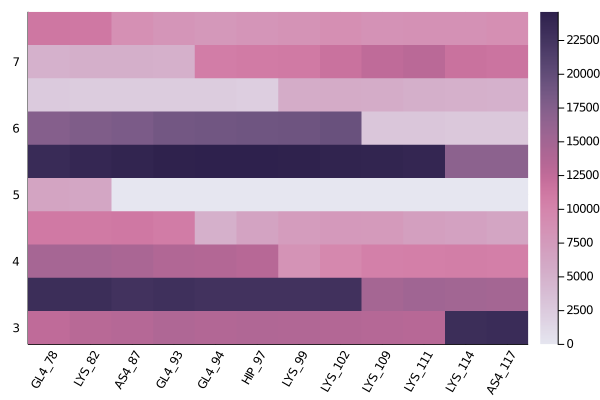

In [245]:
heatmap(titratable_residues[25:end], (phs ./ 10), nhb_cnt_apo_phs[titratable_resis[25:end], :],
    xrotation = 60, color = gradi)